# Exponential smoothing

We will illustrate the family of forecasting techniques based on exponential smoothing:
1. Simple exponential smoothing: Forecasts are based on a weighted average of all past data, with the greatest weight on the most recent observation, and weights declining exponentially into the past.
2. Double exponential smoothing: Forecasts are based on a weighted average of not only the recent *level* of the data, but also its recent *trend.*
3. Triple exponential smoothing (also called Holt-Winters): Forecasts are based on a weighted average of recent level, trend, and seasonal effects.

These techniques are relatively simple, but are also extremely fast, flexible, and powerful ways to build forecasts for a wide range of data series without much knowledge about them. As such, they are some of the most popular forecasting tools in practice.

As always, we start by importing the necessary packages, and the API key to use the FRED system. 

<b>Remember that you need to replace my API key with yours in order to run this code.</b>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import fredapi

from scipy.optimize import minimize

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
Fred_API_key_string = open('/home/william/Fred_API_key.txt').read().rstrip()

## 1. Simple exponential smoothing with PCE inflation

We will illustrate simple exponential smoothing with the monthly rate of inflation in the PCE price index.

First, download and plot the price index since 2010: As always, you do not need to study the details of the code for this step.

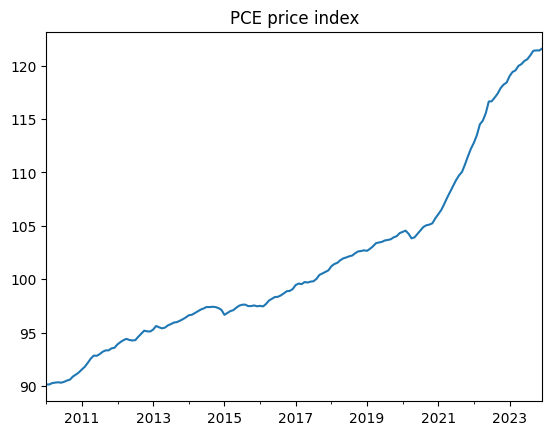

In [28]:
PCEPI  = fredapi.Fred(api_key=Fred_API_key_string).get_series('PCEPI', 
    observation_start = '2010-01-01', observation_end = '2023-12-31', 
    frequency='m')
PCEPI.index = pd.DatetimeIndex(PCEPI.index.values,freq='MS')
PCEPI.plot(title="PCE price index");

Most media reports focus on the year-over-year percentage change in the price index. We can calculate and plot this as follows. It should resemble the kind of charts you may have seen about inflation the last few years. 

To understand the Python syntax below, the "diff(12)" means to subtract today's value minus the value 12 months ago. The "shift(12)" means to get the value 12 months ago. So when we divide these two, we are calculating the growth rate of the index over the last 12 months. Then we multiply by 100 to make this a percentage.

After doing this calculation, we use the dropna() function to delete any missing values (which Python refers to as NaN or "Not a number"). This is just because the first 12 observations will be missing since we have no prior year to compare them with.

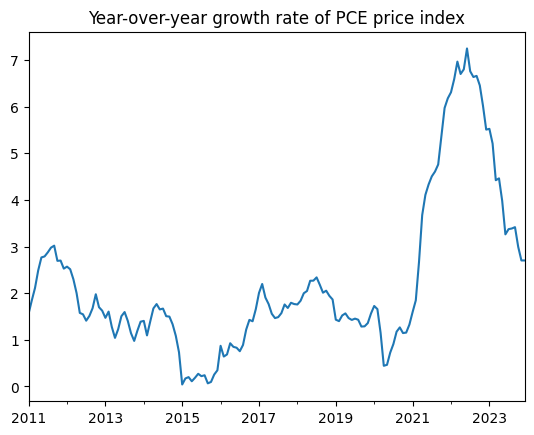

In [29]:
PCEPI_YOY = 100*( PCEPI.diff(12) / PCEPI.shift(12) )
PCEPI_YOY = PCEPI_YOY.dropna()
PCEPI_YOY.plot(title="Year-over-year growth rate of PCE price index");

The media focus on this type of figure because, among other reasons, it already "smooths out" some of the jumpiness of the month-to-month changes. Today we are going to use exponential smoothing as another way of smoothing out that jumpiness. 

So instead of the year-over-year figure above, let's look at the month-to-month growth rate of the price index. As expected, we still see a clear underlying trend, but with much more variation around that trend.

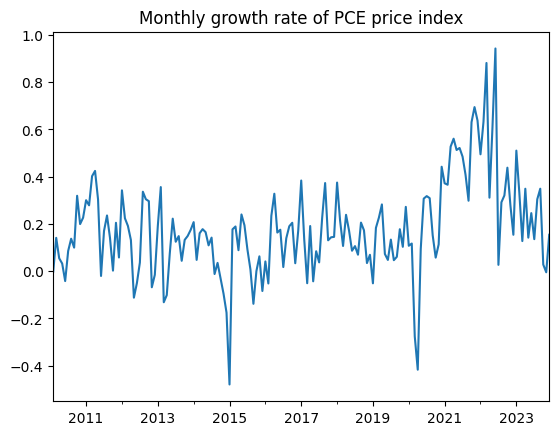

In [5]:
PCEPI_1m = 100*( PCEPI.diff() / PCEPI.shift() )
PCEPI_1m = PCEPI_1m.dropna()
PCEPI_1m.plot(title="Monthly growth rate of PCE price index");

Simple exponential smoothing (SES) will have its own way of trying to smooth out the noise so we can focus on the trend. It is much like smoothing with centered moving averages (last week), but is better for forecasting because it only uses past data (not future data), and applies a weighted-average approach with the most weight on the last observation. 

To run an SES algorithm, we can use the ExponentialSmoothing method (imported at the top of this notebook). In this method we specify the dataset that we want to use (PCEPI_1m), and the options trend=None and seasonal=None to  tell the code that this is simple smoothing, not double or triple (see later examples). Then we use the fit() method to actually run the model. The results are saved in an object called SES_results.

In [6]:
SES_results = ExponentialSmoothing(PCEPI_1m,trend=None,seasonal=None).fit()

Now that we have the results, we can look at lots of information about them. 

First, we can plot the data, and the fitted values from the SES algorithm. Fitted values mean different things in different places in statistics. With exponential smoothing approaches specifically, the "fitted values" are the forecasts that are made at each date, based on all the information available up to that point. So we can compare them with data on the same date to see how well the model performed. 

However, keep in mind that $\alpha$ was chosen to make this performance as good as possible "in-sample." So the true test of the model would be to see how it performs on a *future* dataset ("out of sample").

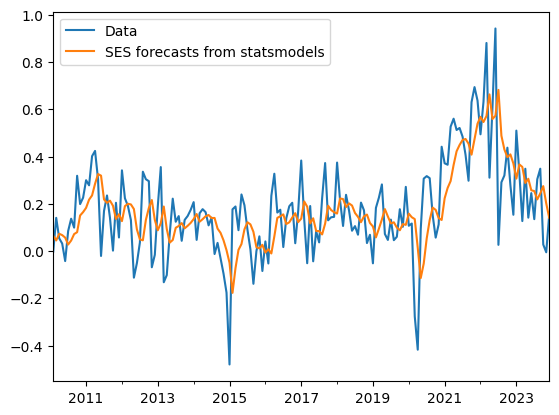

In [7]:
PCEPI_1m.plot(legend=True,label="Data"); 
SES_results.fittedvalues.plot(legend=True,label="SES forecasts from statsmodels");

To compare with the notation in the slides: The blue line above is the raw data on inflation rates (stored in the "PCEPI_1m" object) and is represented as $y_t$ in the slides. The orange line is the list of "forecasts" that we build from the SES procedure and is represented as $F_t$ in the slides.

We can also look at the computer's choice of initial values and model parameters. The output shows us that:

- The computer set its initial "forecast" $F_1$ equal to approximately 0.0651 (listed under 'initial_level'). As discussed in the slides from class, this choice was made through an algorithm that is complicated and difficult for us to match manually. It is also not very important to understand exactly how the computer chose this value, because any choice of $F_1$ will only matter for the first few months in the data.
- After choosing its value of $F_1$, the computer experimented with different value of $\alpha$, until it settled on a value of approximately 0.296 as its optimal choice (listed under 'smoothing_level'). As discussed in the slides from class, this choice was made to minimize the sum of squared forecast errors. The next code block will perform the same approach manually.
- All the other values are missing, because they relate to options that we are not using yet. (This will change in later examples.)

In [8]:
SES_results.params

{'smoothing_level': 0.29594406604813006,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.06510098567887884,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

The code below matches the above results (as closely as we would ever need for practical purposes):

In [9]:
# This function returns a list of one-step forecasts, given a choice of alpha
def SES_forecasts_manual(alpha):
    # Create an empty list of forecasts, with one extra row for the final forecast.
    # To do this, we create an empty series, copying the index of the raw data, and adding one value.
    N = len(PCEPI_1m)
    forecasts = pd.Series(index=PCEPI_1m.index.insert(N,PCEPI_1m.index.max() + 1*PCEPI_1m.index.freq),dtype='float64')
    # Initialize the first "forecast" F1
    # One common approach is to use the first observation from the data:
    forecasts.iloc[0] = PCEPI_1m.iloc[0]
    # If we want to match the statsmodels approach as closely as possible, we can initialize at the value it chose:
    # forecasts.iloc[0] = SES_results.params['initial_level']
    # Fill in the rest of the forecasts following the SES algorithm
    for i in range(0,N):
        forecasts.iloc[i+1] = alpha*PCEPI_1m.iloc[i] + (1-alpha)*forecasts.iloc[i]
    return forecasts

# This function returns the sum of squared one-step forecast errors
def SSE(alpha):
    forecasts = SES_forecasts_manual(alpha)
    errors = PCEPI_1m - forecasts
    SSE = (errors**2).sum()
    return SSE

# Use scipy's minimize function to search for the value of alpha that achieves the lowest SSE.
# The first input is the function that it is trying to minimize, the second is an initial guess about alpha.
optimization_results = minimize(SSE,0)

# Extract that value of alpha from the results
optimal_alpha = optimization_results.x[0]
print("Optimal value of alpha (by hand): " + '%6.5f' % optimal_alpha)

Optimal value of alpha (by hand): 0.30141


Plot our manual forecasts and the statsmodels forecasts for comparison.

- If we initialized $F_1$ at the value that statsmodels chose, we won't be able to see any difference.
- If we initialized it at another value, there will be a slight difference between the two lines in the first few months, then no visible difference after that.

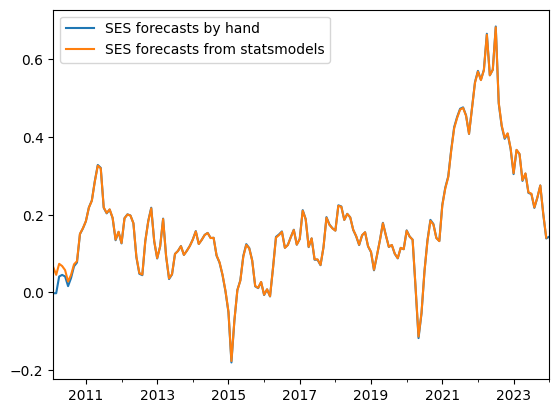

In [10]:
SES_forecasts_manual(optimal_alpha).plot(legend=True,label="SES forecasts by hand");
SES_results.fittedvalues.plot(legend=True,label="SES forecasts from statsmodels");

Finally, the results come with a "forecast" function that can be used to build out-of-sample forecasts beyond the end of the data. However, forecasts from simple exponential smoothing are not very interesting. It's just the most recent average, copied many times over. While SES (like moving-average smoothing) can help *us* to see the trend, the procedure itself does not have any awareness of that trend, only of the current level of the series. Double exponential smoothing (next section) will attempt to improve on this front.

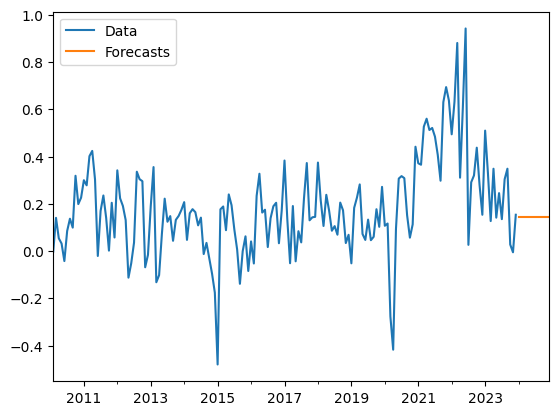

In [11]:
SES_forecasts_OOS = SES_results.forecast(12)
PCEPI_1m.plot(legend=True,label="Data");
SES_forecasts_OOS.plot(legend=True,label="Forecasts");

## 2. Double exponential smoothing with seasonally adjusted GDP

GDP is one of the most widely studied datasets for forecasting, so we will use it for a lot of examples in this class. We start by downloading and visualizing the series. Then we will use it to apply double exponential smoothing.

For this example we will focus on seasonally-adjusted GDP, which is the most widely-reported number. In many settings you will actually want to work with the non-adjusted numbers. We will get to that in the last example, triple exponential smoothing.

Note that this series is reported in billions of dollars, after seasonal adjustments, *and* is annualized (that is, multiplied by 4).
To avoid numerical problems in our manual forecast calculations below, we will divide by 1000 so the numbers are in trillions.
And to compare better with the non-adjusted data in the next section, we will also divide by 4 so the data are no longer annualized.

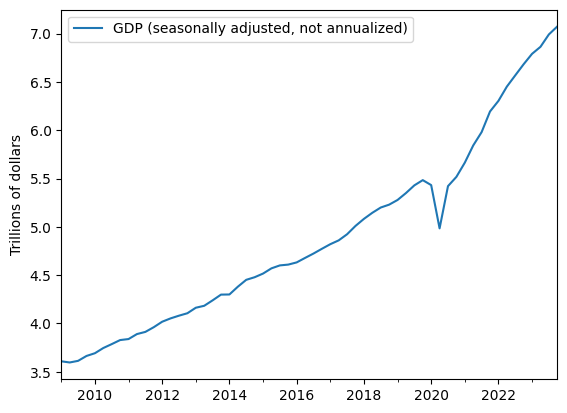

In [12]:
GDP = fredapi.Fred(api_key=Fred_API_key_string).get_series('GDP' , 
    observation_start = '2009-01-01', observation_end = '2023-12-31', 
    frequency='q', aggregation_method = 'eop').resample('QE').first()
GDP = GDP / 1000
GDP = GDP / 4
GDP.plot(legend=True,label="GDP (seasonally adjusted, not annualized)",ylabel="Trillions of dollars");

Clearly, the above series trend upward. Simple exponential smoothing does not work so well in this setting, because it has no way to pick up on that trend: It can only pick up on where the series has recently been, not figure out which direction it is going. For this reason, its "optimal" value turns out to be $\alpha=1$, which means just predicting each next date with wherever the series is right now. This is called a "random walk" forecast and is not much of a model at all.

To illustrate this, let's try estimating a SES model on this series. The model results also contain the sum of squared errors for this model (SES_results.sse). We will compare this with the results of our other approaches below.

SSE: 0.72463
Optimal alpha: 1.00000


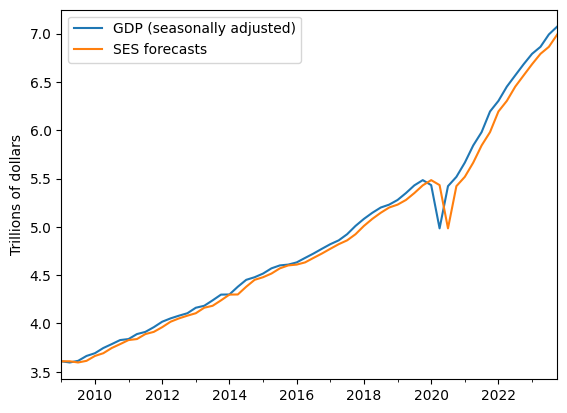

In [13]:
SES_results = ExponentialSmoothing(GDP,trend=None,seasonal=None).fit()
GDP.plot(legend=True,label="GDP (seasonally adjusted)",ylabel="Trillions of dollars")
SES_results.fittedvalues.plot(legend=True,label="SES forecasts")
print("SSE: " + '%6.5f' % SES_results.sse)
print("Optimal alpha: " + '%6.5f' % SES_results.params['smoothing_level'])

Looking at the results, the model just sets $\alpha=1$, which is essentially "giving up" and predicting each date using the previous date.

As with our earlier example, the forecasts that we generate from this approach are just a constant value. But in that earlier example, at least the series really did look likely to stay in the neighborhood of that constant prediction, so you could argue that it was the best prediction we could have hoped for. Here the prediction simply fails to recognize the trend in the data and is just clearly wrong.

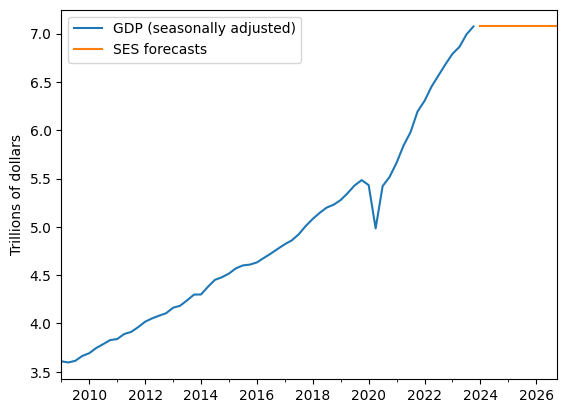

In [14]:
SES_results_OOS = SES_results.forecast(12)
GDP.plot(legend=True,label="GDP (seasonally adjusted)",ylabel="Trillions of dollars");
SES_results_OOS.plot(legend=True,label="SES forecasts");

The figures illustrate the main limitation of the SES procedure, as mentioned above: It has no concept of which way the series is going, only where it is right now.

Double exponential smoothing addresses that limitation, by adding in a notion of "trend" that the model also tries to learn about over time. The model attempts to learn about the trend by comparing the rate of change of the last few observations.

The next code block implements the DES procedure in statsmodels. All we need to do is add the option *trend='additive'* to the code. 

Comparing the results below and above, we can see that this improves the quality of the forecasts, and the "optimal" model is no longer just a random walk. The SSE of the model also falls by a significant amount.

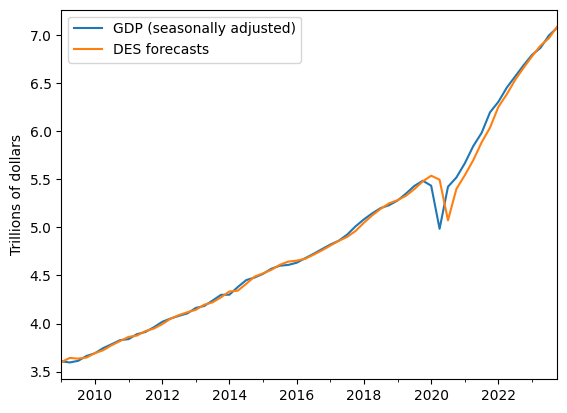

In [15]:
DES_results = ExponentialSmoothing(GDP,trend='additive',seasonal=None).fit()
GDP.plot(legend=True,label="GDP (seasonally adjusted)",ylabel="Trillions of dollars")
DES_results.fittedvalues.plot(legend=True,label="DES forecasts");

In [16]:
DES_results.sse

0.5102514938965698

In [17]:
DES_results.params

{'smoothing_level': 0.8390241203944686,
 'smoothing_trend': 0.0918651883404713,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 3.5635066764390313,
 'initial_trend': 0.03528871266361346,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

The code below matches the above results for all practical purposes. The small differences are because statsmodels uses a slightly different approach to initializing the filter and to optimizing the objective function (as also mentioned in the prior section).

In [18]:
# This function calcultes DES forecasts, given choices of alpha and beta
def DES_manual(params):
    # Now params contains two values, alpha and beta
    alpha = params[0]
    beta = params[1]
    # Create an empty list of forecasts by copying the index of the raw data,
    # and adding one extra row for the last forecast
    forecasts = pd.Series(index=GDP.index.insert(len(GDP),GDP.index.max() + 1*GDP.index.freq),dtype='float64')
    # Initialize both the "level" and the "trend" forecast.
    # One common approach is to set the first "level" forecast equal to the first level of the data,
    # and the firest "trend" forecast equal to the difference of the first two observations.
    # s = GDP[0]
    # b = GDP[1] - GDP[0]
    # If we want to match the statsmodels results as closely as possible, we can use its initial values.
    # Again, these were chosen through an algorithm that is not very important for us to study.
    s = DES_results.params['initial_level']
    b = DES_results.params['initial_trend']
    # Any choice of s and b will rely on some of the early data, and in that sense, is slightly "cheating."
    # To be totally correct, we should exclude these first two observations from our SSE,
    # but this never makes a big enough difference to matter.
    forecasts.iloc[0] = GDP.iloc[0]
    forecasts.iloc[1] = GDP.iloc[1]
    # Now fill in the remaining forecasts following the double ES algorithm.
    for i in range(1,len(GDP)):
        s_old = s
        b_old = b
        s = alpha*GDP.iloc[i] + (1-alpha)*forecasts.iloc[i]
        b = beta*(s - s_old) + (1-beta)*b_old
        forecasts.iloc[i+1] = s+b
    return forecasts

# This function calculates the SSE of the DES procedure, given choices of alpha and beta.
# It uses the function defined just above.
def SSE_DES(params):
    forecasts = DES_manual(params)
    return ((GDP - forecasts)**2).sum()

# Finally, we ask an optimizer to minimize the SSE by searching over values of alpha and beta.
optimal_params = minimize(SSE_DES,[0,0],bounds=[[0,1],[0,1]]).x

In [19]:
# Print out the resulting values.
print("SSE: " + '%5.4f' % SSE_DES(optimal_params))
print("Optimal alpha: " + '%6.5f' % optimal_params[0])
print("Optimal beta: " + '%6.5f' % optimal_params[1])

SSE: 0.5073
Optimal alpha: 0.83848
Optimal beta: 0.09161


Again, we can plot our forecasts calculated by hand against those from statsmodels to check that they are essentially the same.

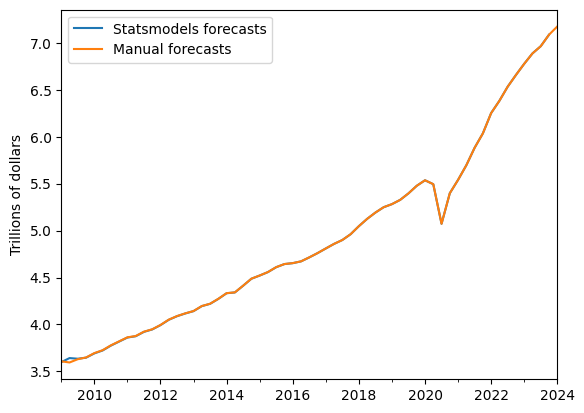

In [20]:
DES_results.fittedvalues.plot(legend=True,label="Statsmodels forecasts",ylabel="Trillions of dollars");
DES_manual(optimal_params).plot(legend=True,label="Manual forecasts");

Finally, we can again build out-of-sample forecasts beyond the end of the data.
The results are clearly more useful than our earlier forecasts based on SES. 
The key difference is that the forecasts now have a notion of which way the series is trending.

In [21]:
DES_forecasts_OOS = DES_results.forecast(12)

In [22]:
DES_forecasts_OOS

2024-03-31    7.173750
2024-06-30    7.271382
2024-09-30    7.369015
2024-12-31    7.466648
2025-03-31    7.564281
2025-06-30    7.661913
2025-09-30    7.759546
2025-12-31    7.857179
2026-03-31    7.954811
2026-06-30    8.052444
2026-09-30    8.150077
2026-12-31    8.247710
Freq: QE-DEC, dtype: float64

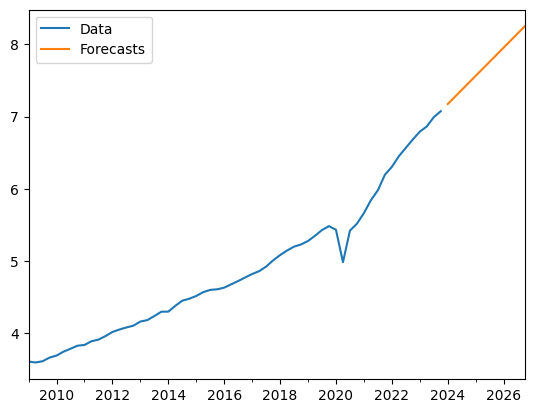

In [23]:
GDP.plot(legend=True,label="Data");
DES_forecasts_OOS.plot(legend=True,label="Forecasts");

## Triple exponential smoothing (Holt-Winters) with non-seasonally-adjusted GDP

Now let's look at the GDP data *without* seasonal adjustment. 

This data series is reported in *millions* of dollars.
So to make it comparable with the results using seasonally-adjusted data, we divide by \$1m.

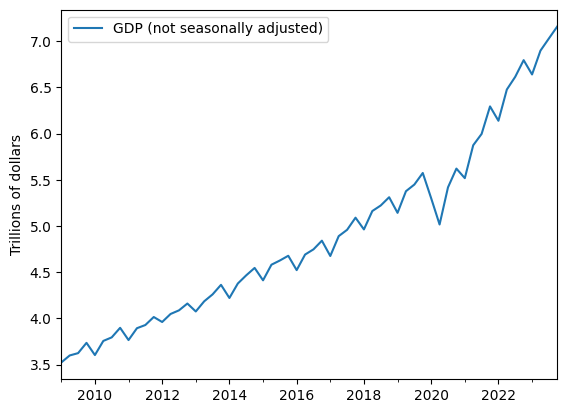

In [24]:
GDPNSA = fredapi.Fred(api_key=Fred_API_key_string).get_series('NA000334Q' , 
    observation_start = '2009-01-01', observation_end = '2023-12-31', 
    frequency='q', aggregation_method = 'eop').resample('QE').first()
GDPNSA = GDPNSA / 1e6
GDPNSA.plot(legend=True,label="GDP (not seasonally adjusted)",ylabel="Trillions of dollars");

Let's see what happens if we try to apply double exponential smoothing to this series.
As we should expect, it fails to pick up on the seasonality of the series.
In some sense it is still right "on average", but, it is also always off by a large amount in any given quarter.

SSE: 1.1250
Smoothing parameter: 0.5355
Smoothing trend: 0.1172


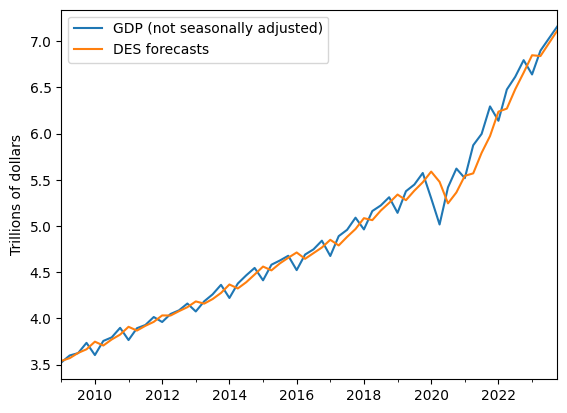

In [25]:
DES_results = ExponentialSmoothing(GDPNSA,trend='additive',seasonal=None).fit()
GDPNSA.plot(legend=True,label="GDP (not seasonally adjusted)",ylabel="Trillions of dollars");
DES_results.fittedvalues.plot(legend=True,label="DES forecasts");
print("SSE: " + '%5.4f' % DES_results.sse)
print("Smoothing parameter: " + '%5.4f' % DES_results.params['smoothing_level'])
print("Smoothing trend: " + '%5.4f' % DES_results.params['smoothing_trend'])

Triple exponential smoothing quickly picks up on the seasonal patterns and gives us better quarterly forecasts. 
The SSE drops roughly in half.

We will not attempt to do this one by hand! But the math is described in the slides, and the basic idea is similar to the other approaches. It just adds a third, year-over-year component that the model also tries to learn about.

Like the trend, the seasonality pieces are thrown off by the initial COVID shock, but by 2023 they appear to be settling back down.

SSE: 0.5031
Smoothing level: 0.8794
Smoothing trend: 0.0856
Smoothing seasonal: 0.0000


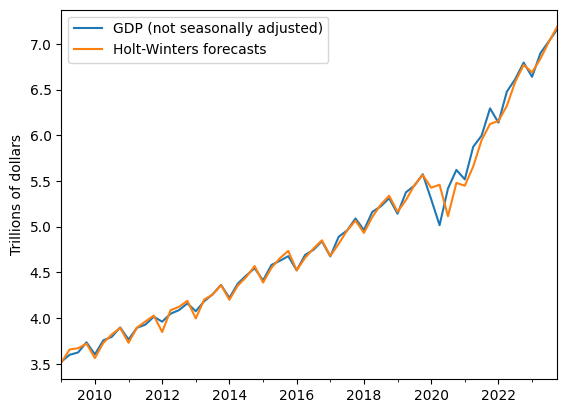

In [26]:
TES_results = ExponentialSmoothing(GDPNSA,trend='additive',seasonal='additive',seasonal_periods=4).fit()
GDPNSA.plot(legend=True,label="GDP (not seasonally adjusted)",ylabel="Trillions of dollars");
TES_results.fittedvalues.plot(legend=True,label="Holt-Winters forecasts")
print("SSE: " + '%5.4f' % TES_results.sse)
print("Smoothing level: " + '%5.4f' % TES_results.params['smoothing_level'])
print("Smoothing trend: " + '%5.4f' % TES_results.params['smoothing_trend'])
print("Smoothing seasonal: " + '%5.4f' % TES_results.params['smoothing_seasonal'])

The seasonal smoothing parameter comes out to zero, but that does *not* mean the model ignores seasonality. It means that the model does not *change* its initial guesses about the seasonal patterns, which were initialized to capture the seasonal patterns in the first two years or so. Seasonality is fairly stable in most series, so it's not too surprising that the model sees little reason to change its initial guess.

Finally, we can again build forecasts beyond the end of the data. Notice how they extrapolate both the trend and seasonality that the data exhibit towards the end of our window.

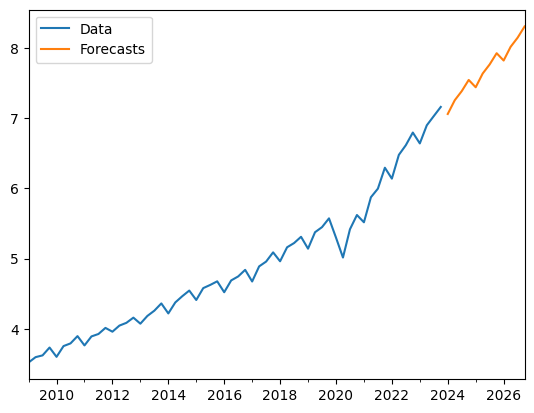

In [27]:
TES_forecasts_OOS = TES_results.forecast(12)
GDPNSA.plot(legend=True,label="Data");
TES_forecasts_OOS.plot(legend=True,label="Forecasts");

The Holt-Winters approach is an extremely popular and powerful forecasting tool in practice! 

- It is often used in situations where you have an economic series to work with, need to quickly create forecasts, and don't have deep insights about the underlying economics of the series. 
- With many business and macreoeconomic data series, the most reliable features of the data are trend and seasonality, and any remaining part is much more difficult to model.
- Holt-Winters will quickly learn about trend and seasonality, and extrapolate them forward to a set of forecasts.
- In principle, you can then improve the forecasts by studying more carefully the residual part of the series, and trying to figure out a good way to model that. But this often turns out to be an extremely difficult exercise that requires lots of time and resources. When those time and resources are not available, Holt-Winters is a very good starting place that can give reasonable forecasts in a matter of seconds, and are actually quite difficult to beat.